In [1]:
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr
from scipy.stats import binned_statistic
import warnings
from soilgasflux_fcs import pareto
warnings.filterwarnings("ignore")

In [2]:
data = {'commercial': {}, 'low-cost': {}}

In [3]:
cm = 1/2.54

test06_noNorm_test5_2025-05-08.nc
test06_MC_noNorm_test5_2025-05-08.nc
expected_test06_2025-05-08.nc
(12, 6) (12, 6)
(11,)
Intensity: low, Curvature: big
Best Pareto x: 6, y: 3
Cutoff: 120, Deadband: 30

(array([ 3,  3,  3,  5,  6,  7, 10, 10, 10, 11, 11]), array([0, 2, 3, 2, 3, 3, 0, 2, 3, 0, 3]))
(12, 6) (12, 6)
(8,)
Intensity: low, Curvature: straight
Best Pareto x: 6, y: 1
Cutoff: 120, Deadband: 10

(array([ 2,  3,  3,  4,  5,  6, 10, 11]), array([1, 0, 1, 1, 1, 1, 1, 0]))
(12, 6) (12, 6)
(12,)
Intensity: medium, Curvature: big
Best Pareto x: 5, y: 2
Cutoff: 110, Deadband: 20

(array([ 2,  4,  4,  4,  5,  7,  8,  9, 10, 11, 11, 11]), array([2, 0, 3, 4, 2, 4, 2, 0, 2, 0, 2, 4]))
(12, 6) (12, 6)
(4,)
Intensity: medium, Curvature: straight
Best Pareto x: 10, y: 5
Cutoff: 160, Deadband: 50

(array([ 2, 10, 10, 11]), array([2, 0, 5, 0]))
(12, 6) (12, 6)
(9,)
Intensity: high, Curvature: big
Best Pareto x: 3, y: 2
Cutoff: 90, Deadband: 20

(array([ 3,  3,  4,  5,  6, 10, 10, 11, 11]), arr

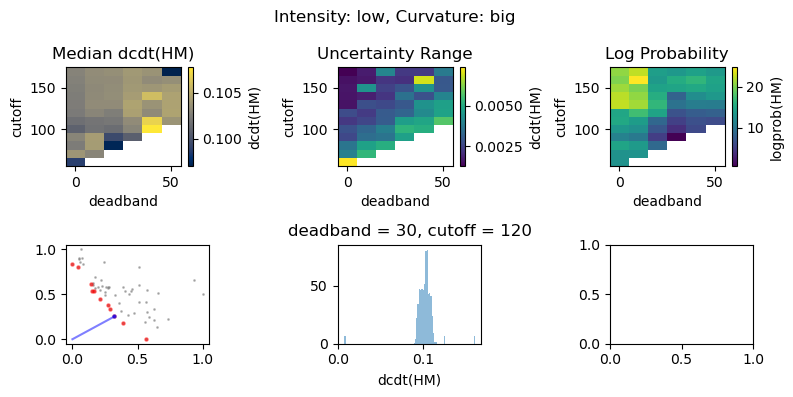

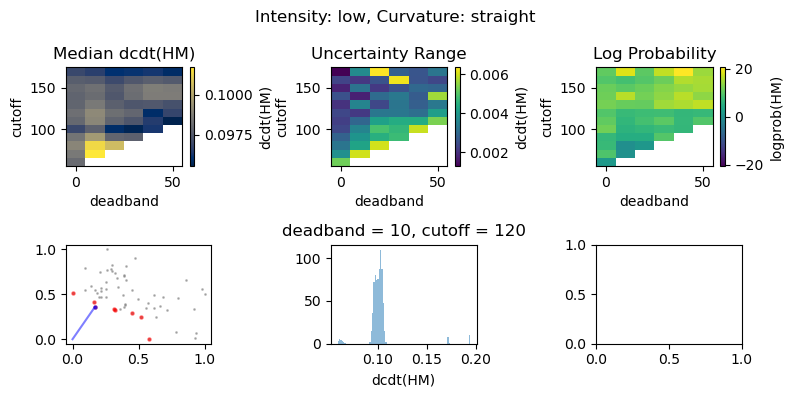

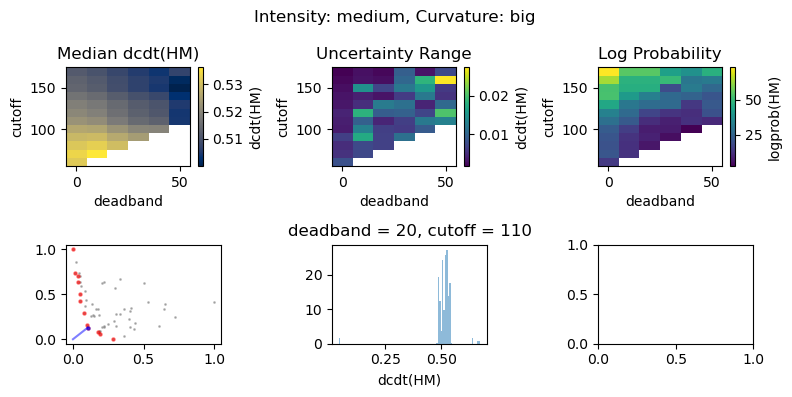

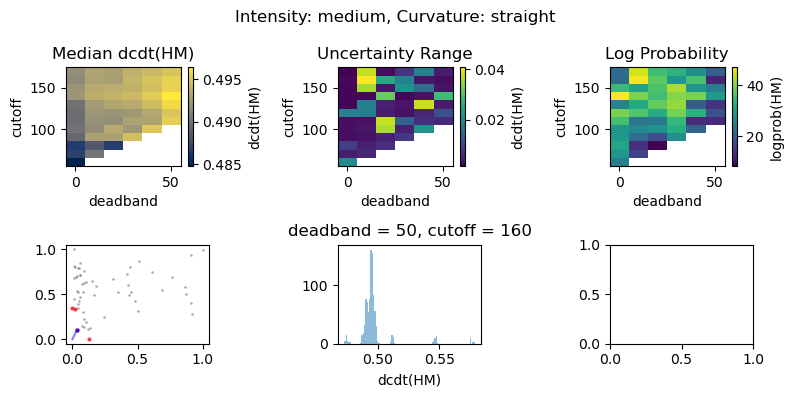

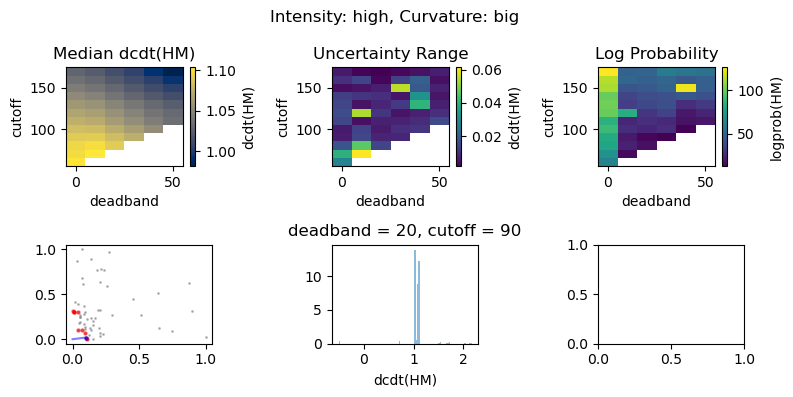

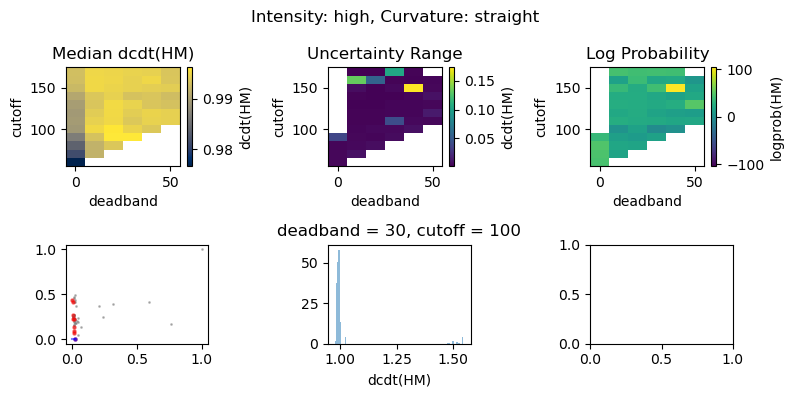

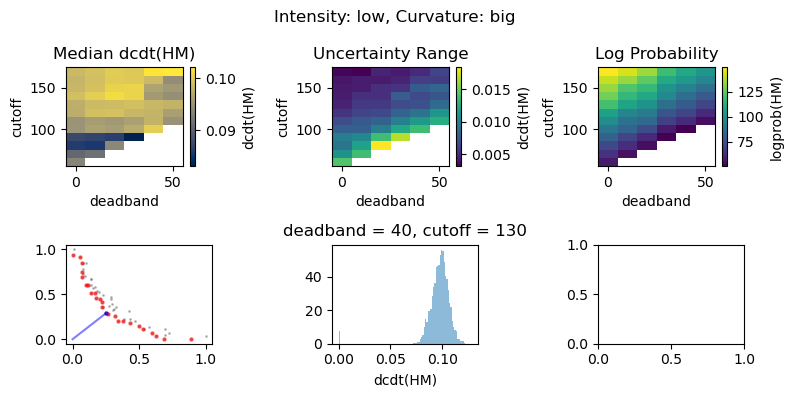

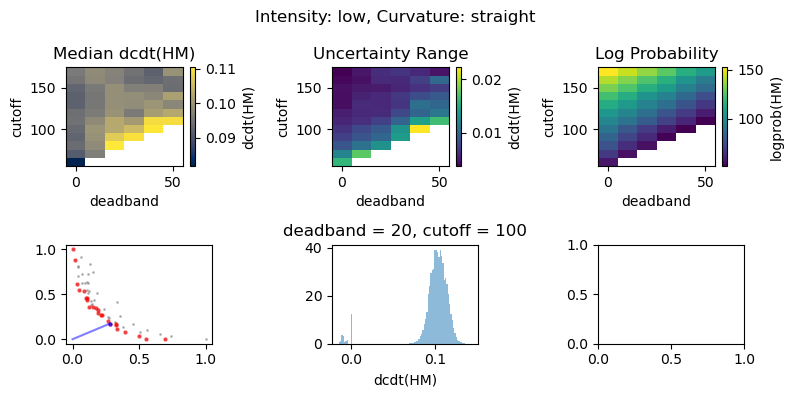

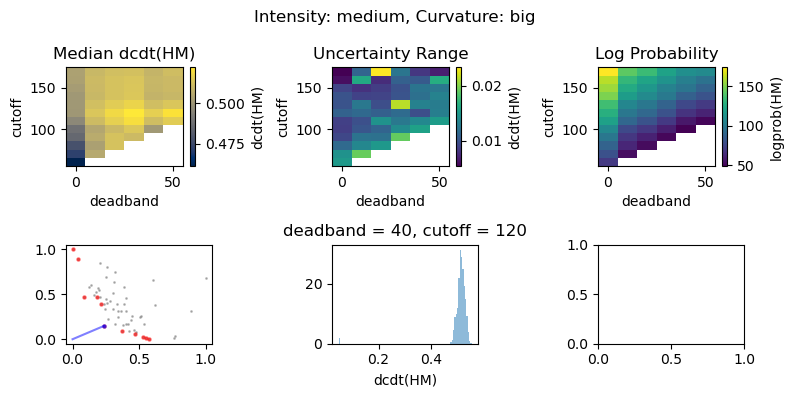

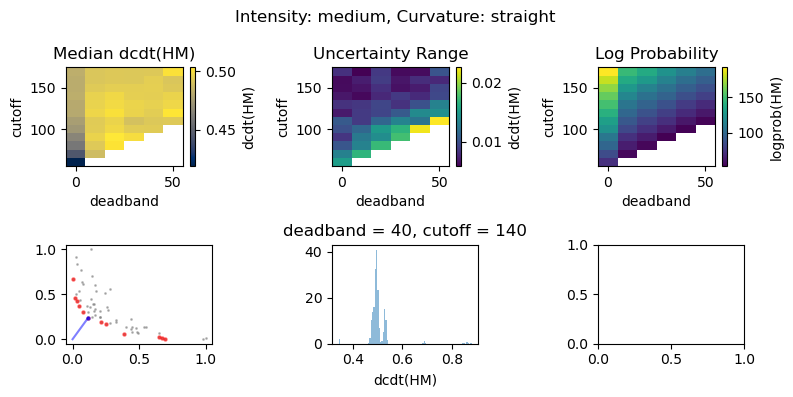

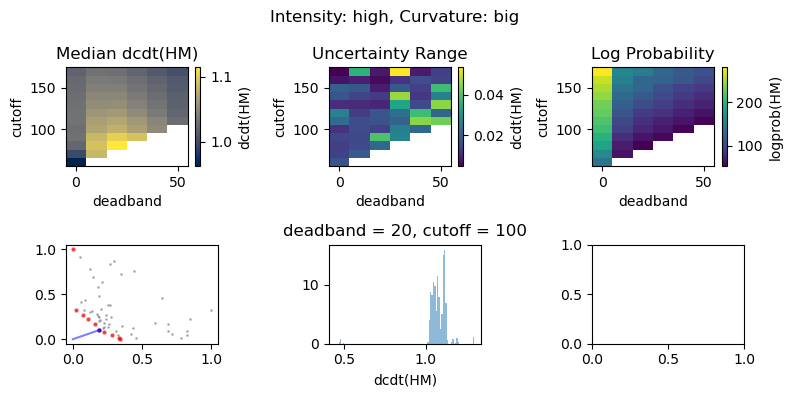

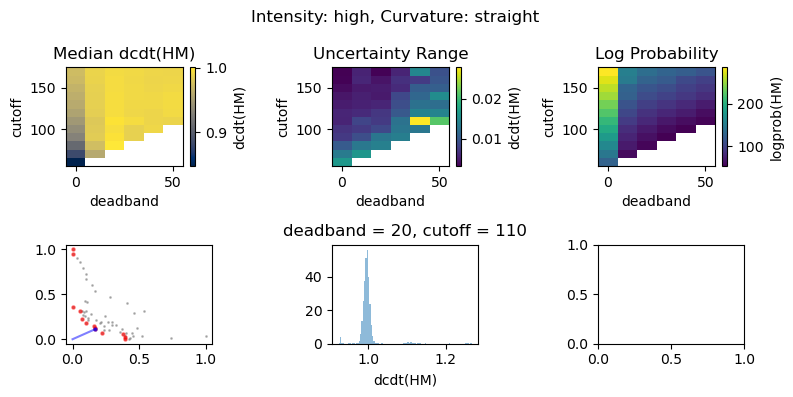

In [4]:
processed_data_path = pathlib.Path('/Users/alexnaokiasatokobayashi/Documents/FCS/processed_data/')

types = ['commercial', 'low-cost']
for i, test_number in enumerate([6,7]):
    # data[types[i]]

    # test_number = 7
    normalizationType = 'no' #['no', 'len', 'yRange']
    # add_info = '_ln_v2test4' #['', '_ln_v2', '_ln_v2test0]
    add_info = '_test5'

    filename_regular = f'test{test_number:02}_{normalizationType}Norm{add_info}_2025-05-08.nc'
    filename_mc = f'test{test_number:02}_MC_{normalizationType}Norm{add_info}_2025-05-08.nc'
    filename_expected = f'expected_test{test_number:02}_2025-05-08.nc'
    print(filename_regular)
    print(filename_mc)
    print(filename_expected)

    ds = xr.open_dataset(processed_data_path / filename_regular)
    dsMC = xr.open_dataset(processed_data_path / filename_mc)
    expected_ds = xr.open_dataset(processed_data_path / filename_expected)
############################################################
    test_a = expected_ds.isel(cutoff=0)['dcdt(HM)'].values
    binned_statistic(test_a, test_a, bins=3)[2]
    # Define your intensity categories
    intensity_labels = ['low', 'medium', 'high']

    # Calculate bin indices (0, 1, or 2)
    bin_indices = binned_statistic(test_a, test_a, bins=3)[2] - 1  # -1 because bins are 1-indexed

    # Map indices to labels
    intensity_categories = np.array(intensity_labels)[bin_indices]
    group_intensity = xr.DataArray(
        intensity_categories,
        coords={'time': expected_ds['time']},
        dims=['time']
    )

    expected_ds = expected_ds.assign_coords(intensity_categories=group_intensity)
######################################################################
    for intensity in ['low', 'medium','high']:
        time_intensity = expected_ds.where(expected_ds['intensity_categories'] == intensity, drop=True)
        cutoff_coords, deadband_coords = ds.coords['cutoff'], ds.coords['deadband']

        for curve in np.unique(time_intensity['curvature'].values):

            data[types[i]][f'{intensity}_{curve}'] = {}

            time_selection = expected_ds.where((expected_ds['intensity_categories'] == intensity) & (expected_ds['curvature'] == curve), drop=True).time.values

            fig, ax = plt.subplots(2, 3, figsize=(8, 4))
            
            mc_hm = dsMC.sel(time=time_selection).median(dim=['MC','time'])['dcdt(HM)']

            pa = pareto.Pareto(dsMC=dsMC.sel(time=time_selection).median(dim=['time']))
            Norm_uncertaintyRange, Norm_logprob, flatNorm_uncertaintyRange, flatNorm_logprob = pa.prepare_metrics()
            pareto_uncertaintyRange_logprob = pa.find_pareto_front(x=flatNorm_uncertaintyRange,
                                                                y=flatNorm_logprob, 
                                                                maximize_x=False, maximize_y=False)
            coords_pareto_uncertaintyRange_logprob = pa.get_coords_pareto(pareto_indices=pareto_uncertaintyRange_logprob)

            best_pareto_x, best_pareto_y = pa.get_best_from_pareto(pareto_indices=pareto_uncertaintyRange_logprob, 
                                                                    metric_x=Norm_uncertaintyRange,
                                                                    metric_y=Norm_logprob)
            uncertaintyRange_hm = pa.uncertaintyRange
            logprob_hm = pa.logprob

            hist_dcdt = dsMC.sel(time=time_selection,
                                deadband=deadband_coords[best_pareto_y].values,
                                    cutoff=cutoff_coords[best_pareto_x].values)['dcdt(HM)']

        
            data[types[i]][f'{intensity}_{curve}']['uncertaintyRange'] = uncertaintyRange_hm.values
            data[types[i]][f'{intensity}_{curve}']['logprob'] = logprob_hm.values
            data[types[i]][f'{intensity}_{curve}']['hist_dcdt'] = hist_dcdt.values
            data[types[i]][f'{intensity}_{curve}']['dcdt_median'] = mc_hm.values
            data[types[i]][f'{intensity}_{curve}']['best_pareto_x'] = best_pareto_x
            data[types[i]][f'{intensity}_{curve}']['best_pareto_y'] = best_pareto_y
            data[types[i]][f'{intensity}_{curve}']['cutoff_best'] = cutoff_coords[best_pareto_x].values
            data[types[i]][f'{intensity}_{curve}']['deadband_best'] = deadband_coords[best_pareto_y].values

            # data[types[i]][f'{intensity}_{curve}']['uncertaintyRange_paretoFront'] = Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob]
            # data[types[i]][f'{intensity}_{curve}']['logprob_paretoFront'] = Norm_logprob[coords_pareto_uncertaintyRange_logprob]
            # data[types[i]][f'{intensity}_{curve}']['uncertaintyRange_best'] = Norm_uncertaintyRange[best_pareto_x, best_pareto_y]
            # data[types[i]][f'{intensity}_{curve}']['logprob_best'] = Norm_logprob[best_pareto_x, best_pareto_y]
            # print(coords_pareto_uncertaintyRange_logprob[0])
            print(uncertaintyRange_hm.shape, logprob_hm.shape)
            print(np.shape(coords_pareto_uncertaintyRange_logprob[0]))
            data[types[i]][f'{intensity}_{curve}']['uncertaintyRange_paretoFront'] = uncertaintyRange_hm.values[coords_pareto_uncertaintyRange_logprob[0], coords_pareto_uncertaintyRange_logprob[1]]
            data[types[i]][f'{intensity}_{curve}']['logprob_paretoFront'] = logprob_hm.values[coords_pareto_uncertaintyRange_logprob[0], coords_pareto_uncertaintyRange_logprob[1]]
            data[types[i]][f'{intensity}_{curve}']['uncertaintyRange_best'] = uncertaintyRange_hm[best_pareto_x, best_pareto_y]
            data[types[i]][f'{intensity}_{curve}']['logprob_best'] = logprob_hm[best_pareto_x, best_pareto_y]
            print(f'Intensity: {intensity}, Curvature: {curve}')
            print(f'Best Pareto x: {best_pareto_x}, y: {best_pareto_y}')
            print(f'Cutoff: {cutoff_coords[best_pareto_x].values}, Deadband: {deadband_coords[best_pareto_y].values}')
            print()

            #### Plots ####
            ds.sel(time=time_selection)['dcdt(HM)'].median(dim='time').plot(ax=ax[0, 0], cmap='cividis')
            uncertaintyRange_hm.plot(ax=ax[0, 1], cmap='viridis')
            logprob_hm.plot(ax=ax[0, 2], cmap='viridis')
            print(coords_pareto_uncertaintyRange_logprob)
            ax[1,0].scatter(flatNorm_uncertaintyRange, flatNorm_logprob, s=1, c='gray', alpha=0.5)
            ax[1,0].scatter(Norm_uncertaintyRange[coords_pareto_uncertaintyRange_logprob], 
                            Norm_logprob[coords_pareto_uncertaintyRange_logprob], 
                            s=5, c='red', alpha=0.5)
            ax[1,0].scatter(Norm_uncertaintyRange[best_pareto_x, best_pareto_y], 
                            Norm_logprob[best_pareto_x,best_pareto_y], s=5, c='blue', alpha=0.5)
            ax[1,0].plot([0, Norm_uncertaintyRange[best_pareto_x, best_pareto_y]], 
                        [0, Norm_logprob[best_pareto_x,best_pareto_y]], c='blue', alpha=0.5)
            
            # ax[1,1].hist(hist_dcdt, density=True, alpha=0.5)
            hist_dcdt.plot.hist(bins=100, density=True, alpha=0.5, ax=ax[1,1])

            fig.suptitle(f'Intensity: {intensity}, Curvature: {curve}')

            ax[0,0].set_title('Median dcdt(HM)')
            ax[0,1].set_title('Uncertainty Range')
            ax[0,2].set_title('Log Probability')
            fig.tight_layout()
            fig.show()
            # break

In [5]:
data['low-cost']['low_big'].keys()

dict_keys(['uncertaintyRange', 'logprob', 'hist_dcdt', 'dcdt_median', 'best_pareto_x', 'best_pareto_y', 'cutoff_best', 'deadband_best', 'uncertaintyRange_paretoFront', 'logprob_paretoFront', 'uncertaintyRange_best', 'logprob_best'])

commercial
	 low_big
(11,)
[11.355101   5.0412846  0.6153636  8.642488   6.7429943  9.752754
 20.146614  13.582218  15.4731655 20.797583  13.54245  ]
	 low_straight
(8,)
[-0.25115606  6.787548    4.867457    5.8481083   6.51154     7.161344
  8.28119    10.493777  ]
	 medium_big
(12,)
[ 6.534872  22.763683   7.8312273  2.321118  11.368993  13.900722
 32.734287  52.309044  47.765427  73.30342   54.95771   37.935677 ]
	 medium_straight
(4,)
[ 8.131965  21.25799   12.0698395 21.652613 ]
	 high_big
(9,)
[14.583049  12.4445305 24.269932  24.43826   19.984947  47.001305
 46.47158   47.18227   48.644554 ]
	 high_straight
(9,)
[ 9.715918   2.7001588 -4.5623736 24.082394  20.14738   19.982754
  5.2579656 42.75142   40.071983 ]
low-cost
	 low_big
(25,)
[ 64.5453    50.519287  57.603256  50.771156  68.69009   53.68085
  95.04351   90.818474  76.510704  70.21988   61.90944  100.92566
  78.906235  70.63662   86.2263    78.40304  133.89165  101.43617
 140.52856  124.72939  110.362816  95.7411   142.

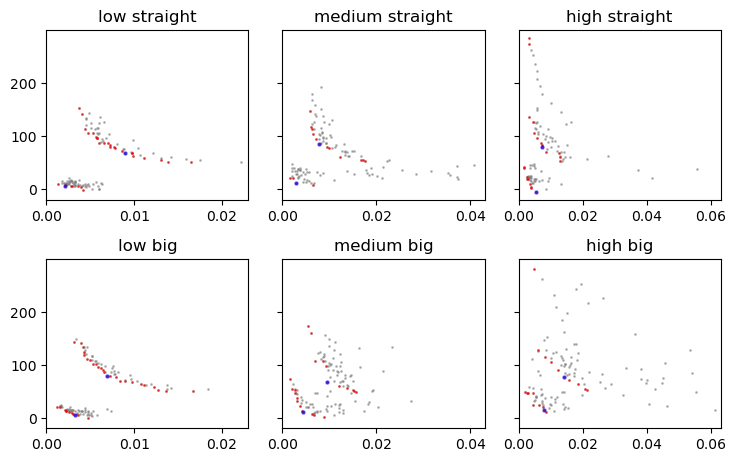

In [6]:
fig, ax = plt.subplots(2,3, figsize=(19*cm, 12*cm), sharey=True)
for settings in data.keys():
    print(settings)
    for intensity_curve in data[settings].keys():
        print('\t',intensity_curve)
        intensity, curve = intensity_curve.split('_')
        
        if intensity == 'low':
            i = 0
        elif intensity == 'medium':
            i = 1
        elif intensity == 'high':
            i = 2
        if curve == 'straight':
            j = 0
        elif curve == 'big':
            j = 1
        ax[j, i].scatter(data[settings][intensity_curve]['uncertaintyRange'],
                        data[settings][intensity_curve]['logprob'], 
                        s=1, c='gray', alpha=0.5)
        print(data[settings][intensity_curve]['uncertaintyRange_paretoFront'].shape)
        print(data[settings][intensity_curve]['logprob_paretoFront'])
        ax[j, i].scatter(data[settings][intensity_curve]['uncertaintyRange_paretoFront'],
                        data[settings][intensity_curve]['logprob_paretoFront'], 
                        s=1, c='red', alpha=0.5)
        ax[j, i].scatter(data[settings][intensity_curve]['uncertaintyRange_best'],
                        data[settings][intensity_curve]['logprob_best'], 
                        s=5, c='blue', alpha=0.5, zorder=10)

        ax[j,i].set_title(f'{intensity} {curve}')

ax[0,0].set_xlim((0, 0.023))
ax[1,0].set_xlim((0, 0.023))

ax[0, 1].set_xlim((0, 0.043))
ax[1, 1].set_xlim((0, 0.043))

ax[0, 2].set_xlim((0, 0.063))
ax[1, 2].set_xlim((0, 0.063))
fig.tight_layout()


=== Creating Combined 6-Subplot Figure (Commercial + Low-cost) ===
Processing High intensity, Big curvature
Processing High intensity, Straight curvature
Processing Low intensity, Big curvature
Processing Low intensity, Straight curvature
Processing Medium intensity, Big curvature
Processing Medium intensity, Straight curvature


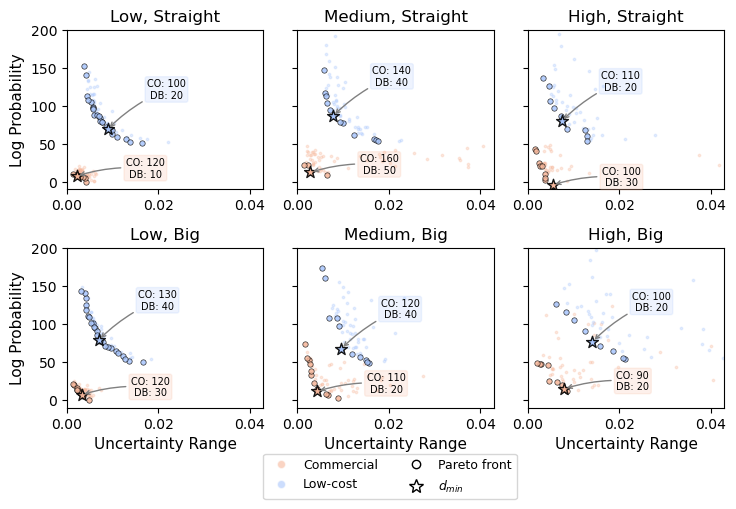


=== 6-subplot combined figure completed! ===


In [7]:
import seaborn as sns
import pandas as pd

colors_p = sns.color_palette('coolwarm', n_colors=2)

# Get all unique intensity-curve combinations
all_combinations = set()
for settings_key in data.keys():
    all_combinations.update(data[settings_key].keys())

print(f"\n=== Creating Combined 6-Subplot Figure (Commercial + Low-cost) ===")

# Create figure with 6 subplots (2 rows × 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(19*cm, 12*cm), sharey=True)
# fig.suptitle('Pareto Analysis: Commercial vs Low-cost Comparison\nAll Intensity and Curvature Combinations', 
#              fontsize=12, y=0.95)

colors = {'commercial': colors_p[1], 'low-cost': colors_p[0]}

# Define subplot positions
intensity_order = ['low', 'medium', 'high']
curve_order = ['straight', 'big']

# Loop through each intensity-curve combination
for intensity_curve_key in sorted(all_combinations):
    intensity, curve = intensity_curve_key.split('_')
    print(f"Processing {intensity.title()} intensity, {curve.title()} curvature")
    
    # Determine subplot position
    if intensity in intensity_order and curve in curve_order:
        col = intensity_order.index(intensity)
        row = curve_order.index(curve)
        ax = axes[row, col]
    else:
        continue
    
    # Combine data from both datasets
    pareto_data = {'commercial': {}, 'low-cost': {}}
    best_data = {'commercial': {}, 'low-cost': {}}
    
    for settings_key in data.keys():
        if intensity_curve_key in data[settings_key]:
            # Prepare main scatter data
            uncertainty_flat = data[settings_key][intensity_curve_key]['uncertaintyRange'].flatten()
            logprob_flat = data[settings_key][intensity_curve_key]['logprob'].flatten()
            
            # Plot all points
            ax.scatter(uncertainty_flat, logprob_flat, 
                      s=3, c=colors[settings_key], alpha=0.3, 
                      label=f'{settings_key.title()}' if curve == 'straight' and intensity == 'low' else "")
            
            # Store Pareto and best data
            pareto_data[settings_key]['uncertainty'] = data[settings_key][intensity_curve_key]['uncertaintyRange_paretoFront']
            pareto_data[settings_key]['logprob'] = data[settings_key][intensity_curve_key]['logprob_paretoFront']
            best_data[settings_key]['uncertainty'] = data[settings_key][intensity_curve_key]['uncertaintyRange_best']
            best_data[settings_key]['logprob'] = data[settings_key][intensity_curve_key]['logprob_best']
            best_data[settings_key]['cutoff'] = data[settings_key][intensity_curve_key]['cutoff_best']
            best_data[settings_key]['deadband'] = data[settings_key][intensity_curve_key]['deadband_best']
    
    # Overlay Pareto front points for each dataset
    for settings_key in pareto_data.keys():
        if pareto_data[settings_key]:
            ax.scatter(pareto_data[settings_key]['uncertainty'], 
                      pareto_data[settings_key]['logprob'], 
                      s=15, c=colors[settings_key], alpha=0.8, 
                      marker='o', edgecolors='k', linewidth=0.5,
                      label=f'{settings_key.title()} Pareto' if curve == 'straight' and intensity == 'low' else "", 
                      zorder=5)
    
    # Best points for each dataset
    for settings_key in best_data.keys():
        if best_data[settings_key]:
            ax.scatter(best_data[settings_key]['uncertainty'], 
                      best_data[settings_key]['logprob'], 
                      s=80, c=colors[settings_key], alpha=0.9, marker='*', 
                      edgecolors='k', linewidth=1, 
                      label=f'{settings_key.title()} Best' if curve == 'straight' and intensity == 'low' else "", 
                      zorder=10)
    
    # Set appropriate x-limits based on intensity
    if intensity == 'low':
        ax.set_xlim((0, 0.043))
        ax.set_ylim((-10, 200))
    elif intensity == 'medium':
        ax.set_xlim((0, 0.043))
        ax.set_ylim((-10, 200))
    elif intensity == 'high':
        ax.set_xlim((0, 0.043))
        ax.set_ylim((-10, 200))
    
    # Add subplot title
    ax.set_title(f'{intensity.title()}, {curve.title()}', fontsize=12)
    
    # Add arrows with annotations for best parameters
    for settings_key in best_data.keys():
        if best_data[settings_key]:
            # Create annotation text
            annotation_text = f"CO: {best_data[settings_key]['cutoff']:.0f}\nDB: {best_data[settings_key]['deadband']:.0f}"
            
            # Position for arrow (offset from best point)
            x_best = best_data[settings_key]['uncertainty']
            y_best = best_data[settings_key]['logprob']
            
            # Calculate offset for annotation placement
            x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
            y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
            
            # Different offsets for each dataset to avoid overlap
            if settings_key == 'commercial':
                x_offset = x_range * 0.35
                y_offset = y_range * 0.05
            else:  # low-cost
                x_offset = x_range * 0.3
                y_offset = y_range * 0.25
            
            # Add annotation with arrow
            ax.annotate(annotation_text,
                       xy=(x_best, y_best),
                       xytext=(x_best + x_offset, y_best + y_offset),
                       fontsize=7,
                       ha='center',
                       va='center',
                       bbox=dict(boxstyle="round,pad=0.2", 
                                facecolor=colors[settings_key], 
                                alpha=0.2,
                                edgecolor=colors[settings_key]),
                       arrowprops=dict(arrowstyle='->', 
                                     connectionstyle="arc3,rad=0.1",
                                     color='grey',
                                     lw=1), zorder=15)
    
    # Set labels
    if row == 1:  # Bottom row
        ax.set_xlabel('Uncertainty Range', fontsize=11)
    if col == 0:  # Left column
        ax.set_ylabel('Log Probability', fontsize=11)

# Move legend outside the figure instead of in the first subplot
# Create custom legend handles for clarity
legend_handles = []
legend_labels = []

# Add dataset labels
from matplotlib.patches import Patch
legend_handles.extend([
    # Patch(facecolor=colors['commercial'], label='Commercial'),
    # Patch(facecolor=colors['low-cost'], label='Low-cost')
])

# Add marker type labels  
from matplotlib.lines import Line2D
legend_handles.extend([
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['commercial'], 
           markersize=6, alpha=0.6, label='Commercial'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['low-cost'], 
           markersize=6, alpha=0.6, label='Low-cost'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=None, 
           markersize=6, markeredgecolor='k', linewidth=0.5, label='Pareto front'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor=None, 
           markersize=10, markeredgecolor='k', linewidth=1, label='$d_{min}$')
])

# Position legend outside the figure
fig.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(0.35, -0.02), 
           fontsize=9, title_fontsize=10, ncols=2)

plt.tight_layout()
plt.show()
        
print("\n=== 6-subplot combined figure completed! ===")

In [12]:
data.keys(), data['commercial'].keys(), data['commercial']['low_straight'].keys()

(dict_keys(['commercial', 'low-cost']),
 dict_keys(['low_big', 'low_straight', 'medium_big', 'medium_straight', 'high_big', 'high_straight']),
 dict_keys(['uncertaintyRange', 'logprob', 'hist_dcdt', 'dcdt_median', 'best_pareto_x', 'best_pareto_y', 'cutoff_best', 'deadband_best', 'uncertaintyRange_paretoFront', 'logprob_paretoFront', 'uncertaintyRange_best', 'logprob_best']))

In [13]:
data['commercial']['low_straight']['dcdt_median']

array([[0.09640823,        nan,        nan,        nan,        nan,
               nan],
       [0.0993337 , 0.10060237,        nan,        nan,        nan,
               nan],
       [0.09848808, 0.09943203, 0.09744647,        nan,        nan,
               nan],
       [0.09860496, 0.09978107, 0.09693395, 0.09661489,        nan,
               nan],
       [0.09822032, 0.09810125, 0.09599563, 0.09708367, 0.09601239,
               nan],
       [0.09890634, 0.09856629, 0.09729492, 0.09796645, 0.09884149,
        0.09577169],
       [0.10090967, 0.10086832, 0.10089988, 0.10011422, 0.09876029,
        0.09889827],
       [0.10047274, 0.10125265, 0.09944525, 0.10147946, 0.09954421,
        0.09859271],
       [0.10062176, 0.09964805, 0.10179863, 0.10173553, 0.09913464,
        0.10068998],
       [0.1002251 , 0.10065383, 0.10095649, 0.1005244 , 0.10007364,
        0.09873812],
       [0.09989826, 0.10035992, 0.10011125, 0.09998654, 0.09780933,
        0.0976848 ],
       [0.10042131, 0